In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from proofreader.utils.vis import plot_3d
import torch
%load_ext autoreload
%autoreload 2
%matplotlib inline

def plot_example(x,y=None,title=None, lim=0.1):
    lim = (lim*-1,lim)
    lim = (lim,lim,lim)
    pc = np.swapaxes(x, 0, 1)
    t = ''
    if y is not None:
        t = y.item() == 1
    if title is not None:
        t = title
    plot_3d(pc, title=t, lims=lim)


In [44]:
from proofreader.data.cremi import prepare_cremi_vols
train_vols, test_vols = prepare_cremi_vols('/mnt/home/jberman/sc/proofreader/dataset/cremi')


In [46]:
for v in train_vols:
    print(len(np.unique(v)))

32678
1506
2240


In [2]:
import torch
from proofreader.utils.vis import *
import numpy as np

# for i in range(1,6):
#     print('NUM SLICES: ', i)
path = f'/mnt/home/jberman/ceph/pf/dataset/DATASET_info_m=True_ns=1_cs=2_t=0_sc=None_test.pt'
X, Y, I = torch.load(f'{path}')


In [ ]:
lens = []
for b in X:
    lens.append(len(b))
lens = np.array(lens)

# if Y[:,0][-1].item() != 1:
#     if Y[:,0].count_nonzero().item() != 0:
#         print(y[:,0])

cutoff = 8
p_sum = 0
for i in range(15):
    p = len(lens[lens==i])/len(lens)
    print(i, p)
    if i > cutoff:
        p_sum += p
print(cutoff, p_sum)
make_histogram(lens, bins=50)

In [ ]:
num_slices = 1
new_cs = 2
for i,x in enumerate(X[200:300]):
    x = x.numpy()
    d, n = x.shape
    z_cords = x[0,:]
    unique_z = np.unique(z_cords)
    drop_start = -1
    for j in range(len(unique_z)-1):
        if unique_z[j]+1 != unique_z[j+1]:
            drop_start = j+1
            break

    if drop_start == -1:
        print(f'could not find drop start for zs {unique_z}, coudl be issue with data')

    top_z, bot_z = unique_z[:drop_start], unique_z[drop_start:]
    top_labels = np.isin(z_cords, top_z).astype(float)
    bot_labels = np.isin(z_cords, bot_z).astype(float)

    print(top_labels)
    print(bot_labels)
    print(bot_labels.shape)




In [118]:
from proofreader.data.cremi import prepare_cremi_vols

train_vols, test_vols = prepare_cremi_vols('/mnt/home/jberman/sc/proofreader/dataset/cremi')

In [119]:
from proofreader.data.augment import Augmentor
from proofreader.data.splitter import SliceDataset

test_vol = test_vols[0]
num_slices = 1
radius = 96
context_slices = 3
num_points = 2048
scale = 1000
z_amt = (context_slices*2+num_slices)-1
augmentor = Augmentor(center=True, shuffle=True,
                        normalize=(z_amt, scale, scale))
dataset = SliceDataset([test_vol], num_slices, radius, context_slices, num_points=num_points, Augmentor=augmentor, truncate_candidates=0, candidate_group=False, scale=scale, verbose=False, allow_multiple=True)
itr = dataset.__iter__()

{'top_class': 348, 'bot_class': 348, 'drop_start': 3, 'drop_end': 4, 'volume_i': 0, 'label': True}


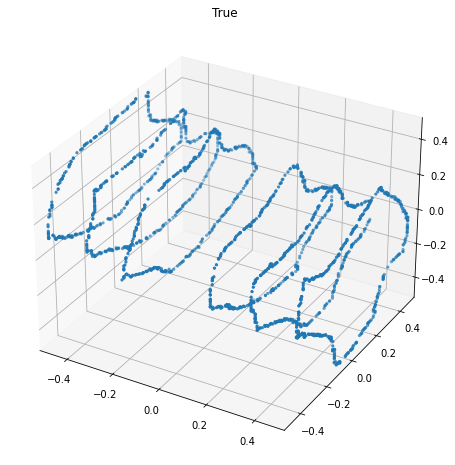

In [120]:
example = next(itr)
x, y, i = example
print(i)
plot_example(x, y=y, lim=0.5)

In [161]:
from proofreader.utils.voi import voi
from collections import defaultdict


all_true_infos = []
grouped = defaultdict(lambda: defaultdict(list)) # vol_i -> drop_start -> [infos]
for info in all_true_infos:
    vol_i, drop_start = info['volume_i'], info['drop_start']
    grouped[vol_i][drop_start].append(info)

# get total voi
(split_del, merge_del) = 0, 0
num_drops = 0
for (vol_i, drops) in grouped.items():
    num_drops += len(drops)
    for drop_start, true_infos in drops.items():
        drop = (drop_start, drop_start+num_slices)
        (split_del, merge_del) += compute_voi_for_drop(vol, drop, true_infos)

(avg_split_del, avg_merge_del) = split_del/num_drops, merge_del/num_drops

def compute_voi_for_drop(vol, drop, true_infos):
    drop_start, drop_end = drop
    # create gt segmentation and split segmentation
    gt = vol.copy()
    gt[drop_start:drop_end] = 0 # drop slices from gt
    split = gt.copy()
    offset = int(np.max(gt))+1 # relabel bot section for split
    split[drop_end:] += offset

    # measure voi before intervention
    (split_pre, merge_pre) = voi(split, gt)

    for info in true_infos:
        # find classes merge neurites
        top_c = info['top_class']
        bot_c = info['bot_class'] + offset # corresponding class in relabel bot section
        split[split == bot_c] = top_c # perform merge on split segmentation

    # measure voi after intervention
    (split_post, merge_post) = voi(split, gt)
    # get change in voi
    split_del, merge_del = split_post - split_pre, merge_post - merge_pre

    print(f'PREFIX voi split: {split_pre}, voi merge: {merge_pre}')
    print(f'POSTFIX voi split: {split_post}, voi merge: {merge_post}')
    print(f'DELTA voi split: {split_del}, voi merge: {merge_del}')
    return (split_del, merge_del)


PREFIX voi split: 0.8566617180534113, voi merge: 0.0
POSTFIX voi split: 0.8566617180534113, voi merge: 3.0460385713966365e-05
DELTA voi split: 0.0, voi merge: 3.0460385713966365e-05
